# Sandbox for simulating and predicting bivariate Guassian random fields

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, "../src")

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

import fields
import model
import sim
import prediction
import plot

%matplotlib inline

In [3]:
vals = [1.1, 1.1, 1.5, 1.5, 1.5, 0.2, 0.2, 0.2, 0.01, 0.01, -0.2]
true_params = model.MaternParams().set_values(vals)
true_params.set_bounds(len_scale = (1e-8, 1.5))
true_mod = model.MultivariateMatern(params=true_params)
true_mod.params.to_dataframe()

,name,value,bounds
0,sigma_11,1.10,"(0.4, 3.5)"
1,sigma_22,1.10,"(0.4, 3.5)"
2,nu_11,1.50,"(0.2, 3.5)"
3,nu_12,1.50,"(0.2, 3.5)"
4,nu_22,1.50,"(0.2, 3.5)"
5,len_scale_11,0.20,"(1e-08, 1.5)"
6,len_scale_12,0.20,"(1e-08, 1.5)"
7,len_scale_22,0.20,"(1e-08, 1.5)"
8,nugget_11,0.01,"(0.0, 0.2)"
9,nugget_22,0.01,"(0.0, 0.2)"


In [4]:
grid = sim.CartesianGrid(xcount=51, ycount=51)
rf = sim.BivariateRandomField(true_mod, grid, seed=1)
samples = rf.sample(frac=0.1, epsilon=0.1)

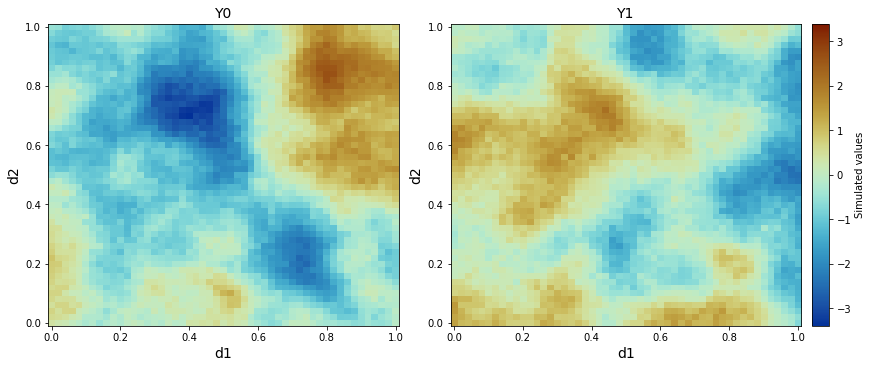

In [5]:
ds_full_fields = rf.to_xarray()
plot.plot_samples(ds_full_fields, fontsize=14)

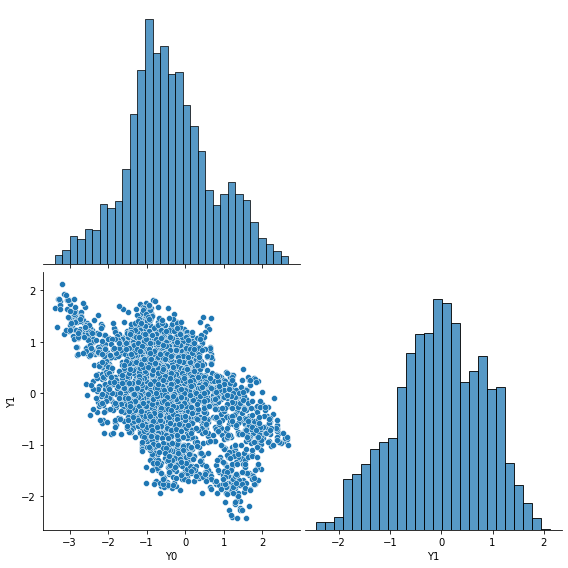

In [6]:
for i, df in enumerate(rf.fields):
    df.rename(columns={"value": f"Y{i}"}, inplace=True)

df_full_fields = pd.merge(*rf.fields, how="outer")
sns.pairplot(df_full_fields, vars=["Y0", "Y1"], corner=True, height=4)

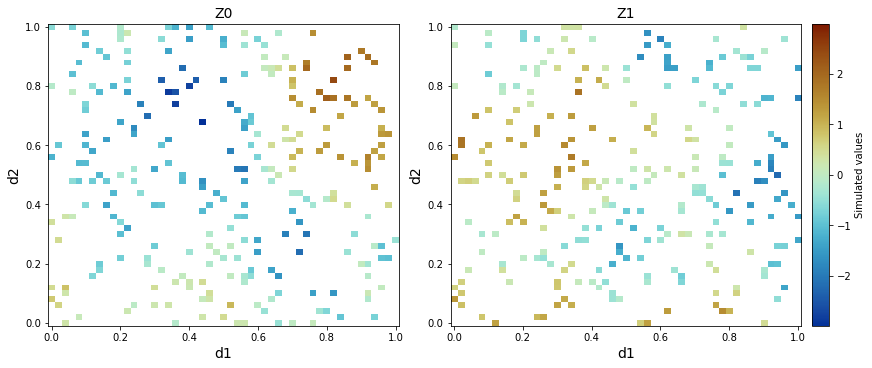

In [7]:
ds_samp = rf.to_xarray(samples)
plot.plot_samples(ds_samp, fontsize=14)

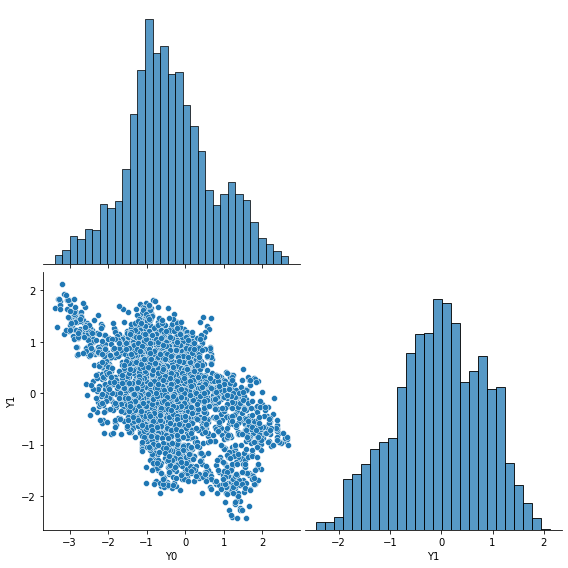

In [8]:
df_full_samp = pd.merge(*samples, how="outer")
sns.pairplot(df_full_fields, vars=["Y0", "Y1"], corner=True, height=4)

## Multivariate Prediction
---

In [22]:
mf = rf.to_fields(samples)
vario_config = fields.VarioConfig(np.sqrt(2)/2, 30, fast_dist=False, dist_units=None)
gamma = mf.empirical_variograms(vario_config)

In [23]:
vals = [1, 1, 1.5, 1.5, 1.5, 1, 1, 1, 0, 0, 0]
guess = model.MaternParams().set_values(vals)
guess.set_bounds(len_scale = (1e-8, 3.5))

mod = model.MultivariateMatern()
mod.fit(gamma, guess=guess)
mod.params.to_dataframe()

,name,value,bounds
0,sigma_11,1.183736,"(0.4, 3.5)"
1,sigma_22,0.909393,"(0.4, 3.5)"
2,nu_11,1.710337,"(0.2, 3.5)"
3,nu_12,3.500000,"(0.2, 3.5)"
4,nu_22,1.332407,"(0.2, 3.5)"
5,len_scale_11,0.221214,"(1e-08, 3.5)"
6,len_scale_12,3.500000,"(1e-08, 3.5)"
7,len_scale_22,0.182091,"(1e-08, 3.5)"
8,nugget_11,0.032544,"(0.0, 0.2)"
9,nugget_22,0.020517,"(0.0, 0.2)"


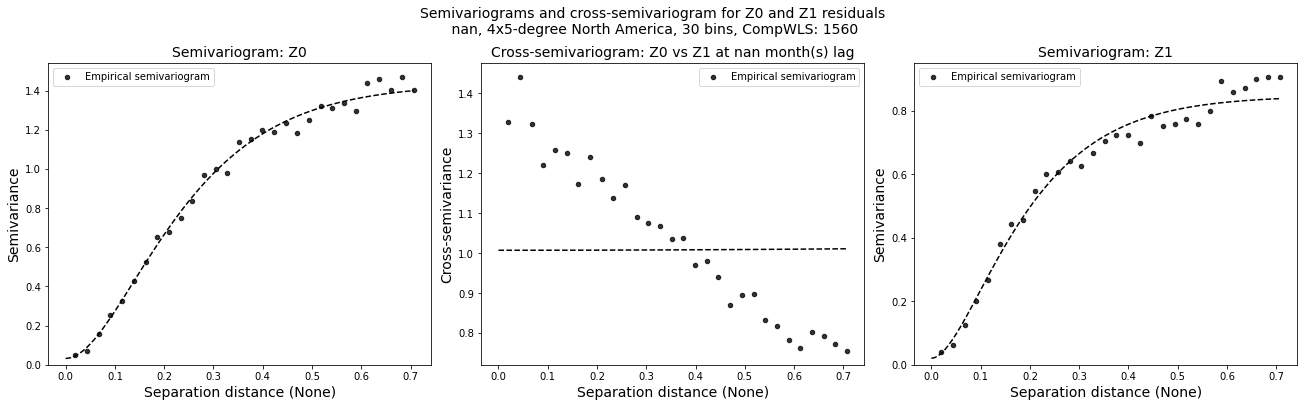

In [28]:
plot.plot_variograms(mod.fit_result, ["Z0", "Z1"], fontsize=14)

In [ ]:
pcoords = grid.coords
P = prediction.Predictor(mod, mf, fast_dist=False, dist_units=None)
ds_pred = P(1, pcoords, max_dist=0.2, postprocess=False)
ds_pred

/Users/joshjacobson/Projects/sif-data-fusion/research/../src/prediction.py:218: UserWarning: Invalid model at prediction location [0.   0.08]. This can happen at data locations.
  warnings.warn(
/Users/joshjacobson/Projects/sif-data-fusion/research/../src/prediction.py:218: UserWarning: Invalid model at prediction location [0.   0.12]. This can happen at data locations.
  warnings.warn(
/Users/joshjacobson/Projects/sif-data-fusion/research/../src/prediction.py:218: UserWarning: Invalid model at prediction location [0.   0.56]. This can happen at data locations.
  warnings.warn(
/Users/joshjacobson/Projects/sif-data-fusion/research/../src/prediction.py:207: RuntimeWarning: invalid value encountered in sqrt
  pred_std = np.sqrt(c0 - np.matmul(cov_weights, local_pred_cov))
/Users/joshjacobson/Projects/sif-data-fusion/research/../src/prediction.py:218: UserWarning: Invalid model at prediction location [0.  0.8]. This can happen at data locations.
  warnings.warn(
/Users/joshjacobson/Projec

<xarray.Dataset>
Dimensions:   (x: 51, y: 51)
Coordinates:
  * x         (x) float64 0.0 0.02 0.04 0.06 0.08 ... 0.92 0.94 0.96 0.98 1.0
  * y         (y) float64 0.0 0.02 0.04 0.06 0.08 ... 0.92 0.94 0.96 0.98 1.0
Data variables:
    pred      (x, y) float64 0.9699 1.023 1.07 1.1 ... -0.5887 -0.4764 -0.3449
    pred_err  (x, y) float64 0.4388 0.3571 0.2772 ... 0.3375 0.3768 0.4383

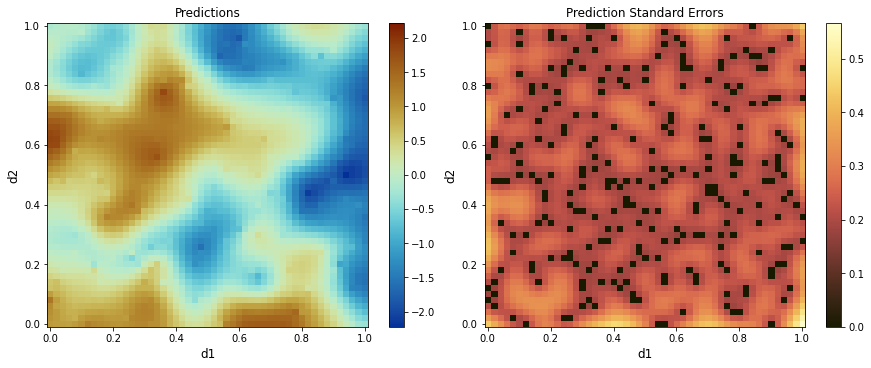

In [ ]:
plot.plot_sim_pred(ds_pred)

In [ ]:
df_cokrig = (
    ds_pred.to_dataframe()
    .reset_index()
    .dropna(subset=["pred"])
    .merge(samples[1], on=["x", "y"], how="right")
)
df_cokrig["diff"] = df_cokrig["Z1"] - df_cokrig["pred"]
df_cokrig[["diff", "pred_err"]].describe()

,diff,pred_err
count,2.610000e+02,2.610000e+02
mean,-1.113613e-16,3.520982e-09
std,1.074160e-15,5.577626e-09
min,-4.218847e-15,0.000000e+00
25%,-6.661338e-16,0.000000e+00
50%,0.000000e+00,0.000000e+00
75%,4.440892e-16,1.053671e-08
max,2.942091e-15,2.107342e-08


## Univariate Prediction
---

In [ ]:
mf = rf.to_fields(samples, i=1)

In [ ]:
bi_vals = mod.params.get_values()[[1, 4, 7, 9]]
mod_uni = model.MultivariateMatern(n_procs=1)
mod_uni.params.set_values(bi_vals)
mod_uni.params.set_bounds(len_scale = (1e-2, 4))
mod_uni.params.to_dataframe()

,name,value,bounds
0,sigma_11,0.909393,"(0.4, 3.5)"
1,nu_11,1.332407,"(0.2, 3.5)"
2,len_scale_11,0.182091,"(0.01, 4)"
3,nugget_11,0.020517,"(0.0, 0.2)"


In [ ]:
pcoords = grid.coords
P = prediction.Predictor(mod_uni, mf, fast_dist=False, dist_units=None)
ds_pred = P(0, pcoords, max_dist=0.2, postprocess=False)
ds_pred

/Users/joshjacobson/Projects/sif-data-fusion/research/../src/prediction.py:218: UserWarning: Invalid model at prediction location [0.   0.08]. This can happen at data locations.
  warnings.warn(
/Users/joshjacobson/Projects/sif-data-fusion/research/../src/prediction.py:218: UserWarning: Invalid model at prediction location [0.   0.12]. This can happen at data locations.
  warnings.warn(
/Users/joshjacobson/Projects/sif-data-fusion/research/../src/prediction.py:218: UserWarning: Invalid model at prediction location [0.   0.56]. This can happen at data locations.
  warnings.warn(
/Users/joshjacobson/Projects/sif-data-fusion/research/../src/prediction.py:218: UserWarning: Invalid model at prediction location [0.  0.8]. This can happen at data locations.
  warnings.warn(
/Users/joshjacobson/Projects/sif-data-fusion/research/../src/prediction.py:218: UserWarning: Invalid model at prediction location [0.   0.94]. This can happen at data locations.
  warnings.warn(
/Users/joshjacobson/Project

<xarray.Dataset>
Dimensions:   (x: 51, y: 51)
Coordinates:
  * x         (x) float64 0.0 0.02 0.04 0.06 0.08 ... 0.92 0.94 0.96 0.98 1.0
  * y         (y) float64 0.0 0.02 0.04 0.06 0.08 ... 0.92 0.94 0.96 0.98 1.0
Data variables:
    pred      (x, y) float64 0.978 1.029 1.073 1.102 ... -0.6074 -0.4998 -0.3778
    pred_err  (x, y) float64 0.4391 0.3573 0.2773 0.2115 ... 0.3377 0.377 0.4387

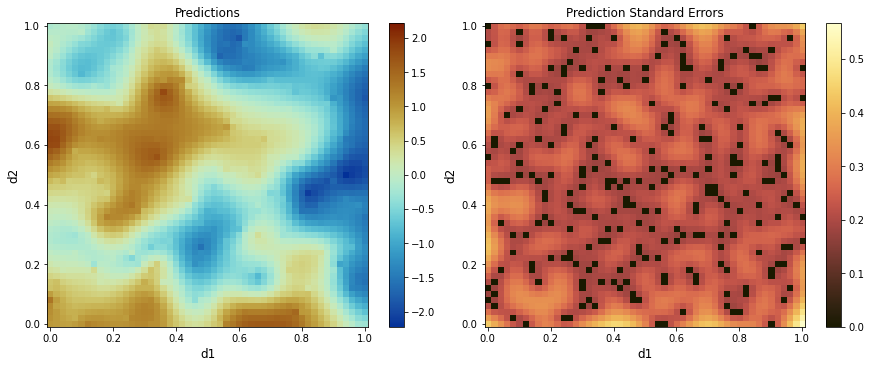

In [ ]:
plot.plot_sim_pred(ds_pred)

In [ ]:
df_krig = (
    ds_pred.to_dataframe()
    .reset_index()
    .dropna(subset=["pred"])
    .merge(samples[1], on=["x", "y"], how="right")
)
df_krig["diff"] = df_krig["Z1"] - df_krig["pred"]
df_krig[["diff", "pred_err"]].describe()

,diff,pred_err
count,2.610000e+02,2.610000e+02
mean,4.586715e-17,3.349537e-09
std,8.505667e-16,5.530309e-09
min,-3.663736e-15,0.000000e+00
25%,-3.330669e-16,0.000000e+00
50%,0.000000e+00,0.000000e+00
75%,4.440892e-16,1.053671e-08
max,3.552714e-15,1.825012e-08
